<h1 align="center">Brain MRI Style Transfer using GAN</h1>

### Author
- Md Junaid Alam

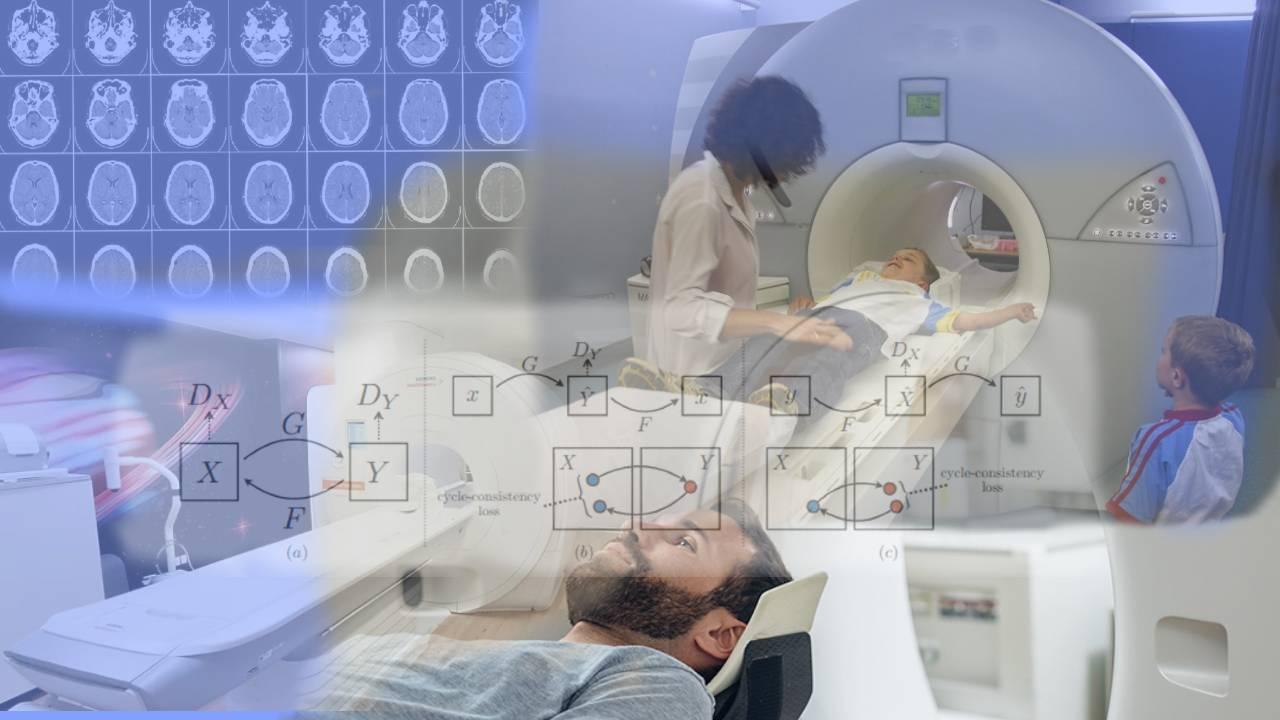

## Domain
- Healthcare

## <font color="brown">Problem Statement</font>

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

We will use CycleGAN to translate the style of one MRI image to another, which will help in a better understanding of the scanned image. Using GANs we will create T2 weighted images from T1 weighted MRI image and vice-versa.

The solution will be to build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

### Project pipeline
The project pipeline can be briefly summarized in the following four steps:

- <b>Data Understanding:</b> Here, we will load the data and create the dataset for it.
- <b>Image Processing:</b> In this step, we will process the images using different steps.
- <b>Model-Building and Training:</b> This is the final step at which we will create our <i>Generators</i> and <i>Discriminators</i> using a modified U-Net architecture(similar to CycleGAN). You also have to define the loss function and training step for model training.

### Required python libraries
The following libraries need to be installed before proceeding:
- <i>numpy</i>
- <i>matplotlib</i>
- <i>tensorflow</i>
- <i>keras</i>
- <i>skimage (or any similar library)</i>
- <i>imageio (or any similar library)</i>
- <i>glob</i>
- <i>os</i>


In [ ]:
# Import all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
import os
import imageio
import glob

### Data Understanding

##### Loading the Data

<b>N.B:</b>- Since I am using Google Colab and I am downloading the provided MRI T1 and T2 zipped image dataset which I uploaded on my google drive and a global UID generated for that image dataset folder (<i>1HnA-0yEDuXPrAnl_sFKQSzXtVhB9qWLh</i>).

I am then referring to that global UID of floder to pull the image dataset from the google drive, by downloading as zip and extracting the zip and deleting the downloaded zip after extraction.

<font color="red">If not using colab to download the zipped image dataset then these steps can be skipped and the image dataset can be placed in the data folder, or we can provide the path of image folder in the path variables of T1 and T2 image dataset.</font>

In [ ]:
# Download the T1 and T2 image data zip file uploaded on my Google Ddrive.
! gdown --id 1HnA-0yEDuXPrAnl_sFKQSzXtVhB9qWLh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1HnA-0yEDuXPrAnl_sFKQSzXtVhB9qWLh
To: /content/data.zip
100% 1.83M/1.83M [00:00<00:00, 161MB/s]


In [ ]:
# Unzip the downloaded image data zip file
!7z x data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1825524 bytes (1783 KiB)

Extracting archive: data.zip
--
Path = data.zip
Type = zip
Physical Size = 1825524

  0%    Everything is Ok

Folders: 3
Files: 89
Size:       1811386
Compressed: 1825524


In [ ]:
# Delete the original zip file after extraction is complete
if os.path.exists("/content/data.zip"):
  os.remove("/content/data.zip")
else:
  print("The data.zip file is already removed or does not exist")

In [ ]:
images_folders = ["data/T1", "data/T2"]
t1_mri = os.listdir(images_folders[0])
t2_mri = os.listdir(images_folders[1])

In [ ]:
#check the first 5 items from the list of both T1 and T2 MRI images to validate
print(t1_mri[:5])
print(t2_mri[:5])

['Image #55.png', 'Image #40.png', 'Image #44.png', 'Image #38.png', 'Image #13.png']
['Image #77.png', 'Image #114.png', 'Image #113.png', 'Image #93.png', 'Image #99.png']


In [ ]:
print("Total T1 images are: {0}".format(len(t1_mri)))
print("Total T2 images are: {0}".format(len(t2_mri)))

Total T1 images are: 43
Total T2 images are: 46


In [ ]:
# Check any of the image as a numpy array
imageio.imread(images_folders[0]+"/"+t1_mri[2])

Array([[1, 1, 1, ..., 1, 1, 1],
       [1, 2, 2, ..., 2, 2, 1],
       [1, 2, 2, ..., 2, 2, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Define an Image pre-processor class that has all the methods to process and display images
class ImagePreProcessor:

  # Method to convert images to numpy arrays
  def image_as_array(self, basepath, imagefolder):
    images_list = []
    for file in imagefolder:
        image = imageio.imread(basepath+ '/' + file)
        images_list.append(image)
    return np.asarray(images_list) # converts list to a numpy array

  # Method to normalize image to [-1.0, 1.0]
  def normalize_image(self, image):
    image = (image/127.5)-1.0
    return image

  # Method to resize images to (64,64) by default
  def resize_images(self, images, dim=64):
    image_resized = np.zeros((images.shape[0], dim, dim))
    for index, image in enumerate(images):
      image_resized[index, :, :] = resize(image, (dim, dim))
    return image_resized

  # Method to reshape images to (64,64, 1) by default to grayscale
  def reshape_images(self, images, dim=64, channel=1):
    image_reshaped =images.reshape(images.shape[0], dim, dim, channel)
    image_reshaped = image_reshaped.astype('float32')
    return image_reshaped


In [ ]:
# Instantiate the ImagePreProcessor class
imgpreprocessor = ImagePreProcessor()

In [ ]:
# Data loading
t1 = imgpreprocessor.image_as_array(images_folders[0], t1_mri)
t2 = imgpreprocessor.image_as_array(images_folders[1], t2_mri)
print('T1 Shape is ', t1.shape)
print('T2 Shape is ', t2.shape)
print('Total images of T1 is ',t1.shape[0])
print('Total images of T2 is ',t2.shape[0])
print('Total size of the Image Dataset is ', t1.shape[0]+t2.shape[0])

T1 Shape is  (43, 217, 181)
T2 Shape is  (46, 217, 181)
Total images of T1 is  43
Total images of T2 is  46
Total size of the Image Dataset is  89


##### Visualize the Image Data

In [ ]:
# Define a function to display image
def display(img, title=None):
  plt.figure(figsize=(2, 2))
  plt.imshow(img, cmap='gray')
  if(title!=None):
    plt.title(title)
  plt.axis('off')
  plt.show()

In [ ]:
# Define a function for multiple display
def displayMultiple(images, title, figsize, rows, cols, persist=False, epoch=0):
  plt.figure(figsize=figsize)
  for i in range(rows*cols):
      plt.subplot(rows, cols, i+1)
      plt.title(title[i])
      if(len(images[i].shape)>3): # handle according to shape
        plt.imshow(images[i][0].numpy()[:, :, 0], cmap='gray')
      else:
        plt.imshow(images[i].numpy()[:, :, 0], cmap='gray')
      plt.axis('off')
  if(persist):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

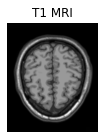

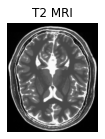

In [ ]:
# # Display any 1 image each from T1 and T2 MRI
image_index=0
display(t1[image_index], "T1 MRI")
display(t2[image_index], "T2 MRI")

### Image Preprocessing

##### Normalize the Image

In [ ]:
# Normalize t1 and t2 images
t1 = imgpreprocessor.normalize_image(t1)
t2 = imgpreprocessor.normalize_image(t2)

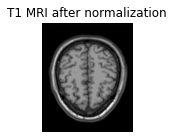

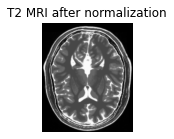

In [ ]:
# Display any 1 image from T1 and T2 MRI after normalization to check
display(t1[image_index], "T1 MRI after normalization")
display(t2[image_index], "T2 MRI after normalization")

##### Resize and reshape the images

In [ ]:
# Resize T1 and T2 images
t1 = imgpreprocessor.resize_images(t1)
t2 = imgpreprocessor.resize_images(t2)
print('T1 Shape after resize is ', t1.shape)
print('T2 Shape after resize is ', t2.shape)

T1 Shape after resize is  (43, 64, 64)
T2 Shape after resize is  (46, 64, 64)


In [ ]:
# Reshape Images to (64, 64, 1) and typescast it to float
t1 = imgpreprocessor.reshape_images(t1)
t2 = imgpreprocessor.reshape_images(t2)
print('T1 Shape after reshape is ', t1.shape)
print('T2 Shape after reshape is ', t2.shape)

T1 Shape after reshape is  (43, 64, 64, 1)
T2 Shape after reshape is  (46, 64, 64, 1)


In [ ]:
# Define a Batch size to create batch and shuffle data
BATCH_SIZE = 32
random_seed = 42
t1 = tf.data.Dataset.from_tensor_slices(t1).shuffle(t1.shape[0], seed=random_seed).batch(BATCH_SIZE)
t2 = tf.data.Dataset.from_tensor_slices(t2).shuffle(t2.shape[0], seed=random_seed).batch(BATCH_SIZE)

In [ ]:
# Select any one of the resized images each from T1 and T2
t1_image = next(iter(t1))
t2_image = next(iter(t2))

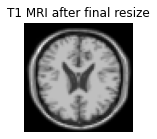

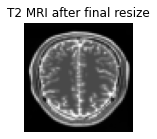

In [ ]:
# Visualize any one of those image
image_index=3
display(t1_image[image_index].numpy()[:, :, 0], "T1 MRI after final resize")
display(t2_image[image_index].numpy()[:, :, 0], "T2 MRI after final resize")

### Model-Building and Training

##### Instance Normalization
Let us now create a class for Instance Normalization. It is specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

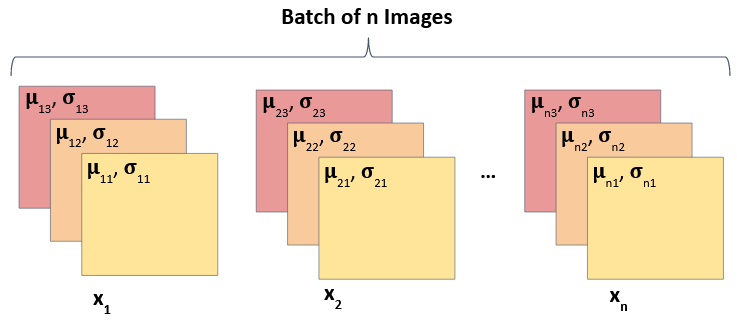

In [ ]:
# Define a class having methods for Instance normalization of images
# This class is a sub class of Layer class in tensorflow
class InstanceNormalization(tf.keras.layers.Layer):
    # Define Constructor
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
        
    # Override the call method that would compute Mean and Variance
    # The attribute axes=[1,2] ensures Instance Normalization
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

Create a class called CycleGAN which would encapsulate the method to create U-net generators and discriminators.
The U-Net architecture is combination of Convolution and Transposed Convolution Layers as given in the diagram below.

<font color="red">Reference Link for the U-Net Technical Paper: </font><a href="https://arxiv.org/pdf/1505.04597.pdf">https://arxiv.org/pdf/1505.04597.pdf</a>

<center>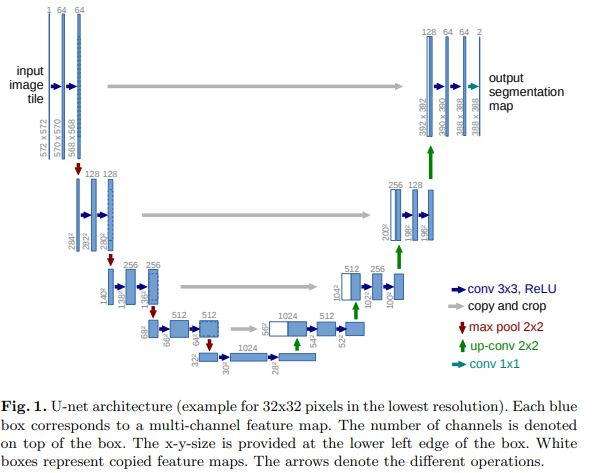</center>

In [ ]:
# Create the CycleGAN class
class CycleGAN:
  # Define a Constructor
  def __init__(self, tf, instanceNormalization):
    self.tf=tf
    self.instanceNormalization = instanceNormalization

  # Method for Downsampling, it reduces dimensions due to convolutions
  def downsample(self, filters, size, apply_norm=True):
    initializer = self.tf.random_normal_initializer(0., 0.02)
    result = self.tf.keras.Sequential()
    # Adding Conv2d layer
    result.add(self.tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Adding InstanceNormalization layer based on the condition
    if apply_norm:
        result.add(self.instanceNormalization())
    # Adding Activation of Leaky Relu
    result.add(self.tf.keras.layers.LeakyReLU())
    return result

  # Method for Upsampling that uses Conv2DTranspose 
  def upsample(self, filters, size, apply_dropout=False):
    initializer = self.tf.random_normal_initializer(0., 0.02)
    result = self.tf.keras.Sequential()
    # Adding Transposed Conv2d layer
    result.add(self.tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Adding InstanceNormalization Layer
    result.add(self.instanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(self.tf.keras.layers.Dropout(0.5))
    # Adding Relu Activation Layer
    result.add(self.tf.keras.layers.ReLU())
    return result

  # define a generate method that would generate the U-Net
  def create_unet_generator(self):
    down_stack = [
        self.downsample(128, 4, False),
        self.downsample(256, 4),
        self.downsample(256, 4),
        self.downsample(256, 4),
        self.downsample(256, 4),
        self.downsample(256, 4)
    ]
    up_stack = [
        self.upsample(256, 4, True),
        self.upsample(256, 4, True),
        self.upsample(256, 4),
        self.upsample(256, 4),
        self.upsample(128, 4)
    ]
    initializer = self.tf.random_normal_initializer(0., 0.02)
    last = self.tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 64, 64, 1)
    concat = self.tf.keras.layers.Concatenate()
    inputs = self.tf.keras.layers.Input(shape=[64, 64, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return self.tf.keras.Model(inputs=inputs, outputs=x)

  
  # Method to create Discriminator which only contains Convolutional Layers 
  def create_discriminator(self):
    initializer = self.tf.random_normal_initializer(0., 0.02)
    # adding an input layer of size (64, 64, 1)
    inp = self.tf.keras.layers.Input(shape=[64, 64, 1], name='input_image')
    x = inp
    
    # steps for downsampling
    down1 = self.downsample(128, 4, False)(x)
    down2 = self.downsample(256, 4)(down1)
    # adding a padding layer
    zero_pad1 = self.tf.keras.layers.ZeroPadding2D()(down2)
    
    # implementing a concrete downsampling layer
    conv = self.tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    norm1 = self.instanceNormalization()(conv)
    leaky_relu = self.tf.keras.layers.LeakyReLU()(norm1)
    
    # applying a zero padding layer
    zero_pad2 = self.tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    # adding a last layer which is a pure 2D Convolution layer
    last = self.tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return self.tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
# Create an instance of UNETGenerator
cycleGAN = CycleGAN(tf, InstanceNormalization)

##### Create the Generators

In [ ]:
# Create the 2 U-Net generators
unet_generatorG = cycleGAN.create_unet_generator()
unet_generatorF = cycleGAN.create_unet_generator()

Let us  check the summary of one of our Generator Models since Both our Generators have same architecture.

In [ ]:
# Let us check the summary of the U-Net generator
print(unet_generatorG.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 128)  2048        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 16, 16, 256)  524800      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 8, 8, 256)    1049088     ['sequential_1[0][0]']           
                                                                                              


**From the generator summary above we notice how the dimension reduces first but then increases.**

##### Create the Discriminator

In [ ]:
# create the 2 discriminators
discriminatorX = cycleGAN.create_discriminator()
discriminatorY = cycleGAN.create_discriminator()

In [ ]:
# Let us check the summary of the discriminator
print(discriminatorX.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 sequential_22 (Sequential)  (None, 32, 32, 128)       2048      
                                                                 
 sequential_23 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 18, 18, 256)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 512)       2097152   
                                                                 
 instance_normalization_21 (  (None, 15, 15, 512)      1024      
 InstanceNormalization)                                    

**If we have a look at Discriminator's summary above, we notice that The dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.**

Let us verify the output of the untrained U-Net generator models to check if it generates a random noise.

In [ ]:
# Pass the T1 and T2 images to the U-Net generators created
to_t2 = unet_generatorG(t1_image)
to_t1 = unet_generatorF(t2_image)
imgs = [t1_image, to_t2, t2_image, to_t1]
title = ['T1 Image', 'Convolved to T2', 'T2 Image', 'Convolved to T1']

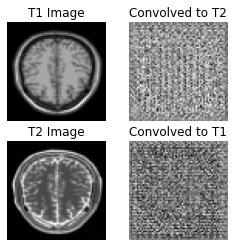

In [ ]:
# Display the corresponding generated convolved images
displayMultiple(imgs, title, (4,4), rows=2, cols=2)

#### Loss Functions

We will create a class encapsulating the following loss functions:
- Discriminator Loss
- Generator Loss
- Cycle Loss
- Identity Loss

Now let us first understand each loss functions in brief

**Discriminator Loss**<br/>
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

**Generator Loss**<br/>
It has only one type of loss - Discriminator Loss on Generated data

**Cycle Loss**<br/>
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

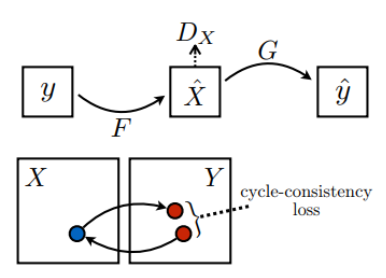

**Identity Loss**<br/>
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

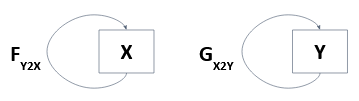

In [ ]:
# Create a class for the loss functions
class LossFunctions:
  # Define a constructor
  def __init__(self, tf):
    # Calculate Binary Cross Entropy Loss (BCE)
    self.loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.tf = tf

  # Method for calculating Discriminator Loss which is real Loss + fake Loss)
  def discriminator_loss(self, real, generated):
    real_loss = self.loss_obj(self.tf.ones_like(real), real)
    generated_loss = self.loss_obj(self.tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

  # Method for calculating Generator Loss
  def generator_loss(self, generated):
    return self.loss_obj(self.tf.ones_like(generated), generated)

    # Method for calculating Cycle Loss
  def calc_cycle_loss(self, real_image, cycled_image):
    l1_loss = self.tf.reduce_mean(self.tf.abs(real_image - cycled_image))
    return 10.0 * l1_loss

    # Method for calculating Identity Loss
  def identity_loss(self, real_image, same_image):
    loss = self.tf.reduce_mean(self.tf.abs(real_image - same_image))
    return 0.5*loss


In [ ]:
# Let us use the Adam optimizer for both generators and the discriminators
generatorG_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generatorF_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminatorX_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminatorY_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

##### Initialize the checkpoints

In [ ]:
# Initialize checkpoints to save models
checkpoint_path = "./model_checkpoints"

checkpoint = tf.train.Checkpoint(generator_g=unet_generatorG,
                           generator_f=unet_generatorF,
                           discriminator_x=discriminatorX,
                           discriminator_y=discriminatorY,
                           generator_g_optimizer=generatorG_optimizer,
                           generator_f_optimizer=generatorF_optimizer,
                           discriminator_x_optimizer=discriminatorX_optimizer,
                           discriminator_y_optimizer=discriminatorY_optimizer)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=3)

# Restore the latest checkpoint if it exists
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print ('The latest checkpoint is restored!!')

In [ ]:
# Definition to show generated output whilst training
def generate_images(generatorG, image1, generatorF, image2, epoch):
    generated1 = generatorG(image1)
    generated2 = generatorF(image2)
    display_list = [image1[0], generated1[0], image2[0], generated2[0]]
    title = ['T1 Input Image', 'Generated Image', 'T2 Input Image', 'Generated Image']
    displayMultiple(display_list, title, (8, 4), 1, 4, True, epoch)

In [ ]:
# Create an instance of LossFunctions passing tf in the constructor
lossFunctions = LossFunctions(tf)

##### Define the function for the training flow

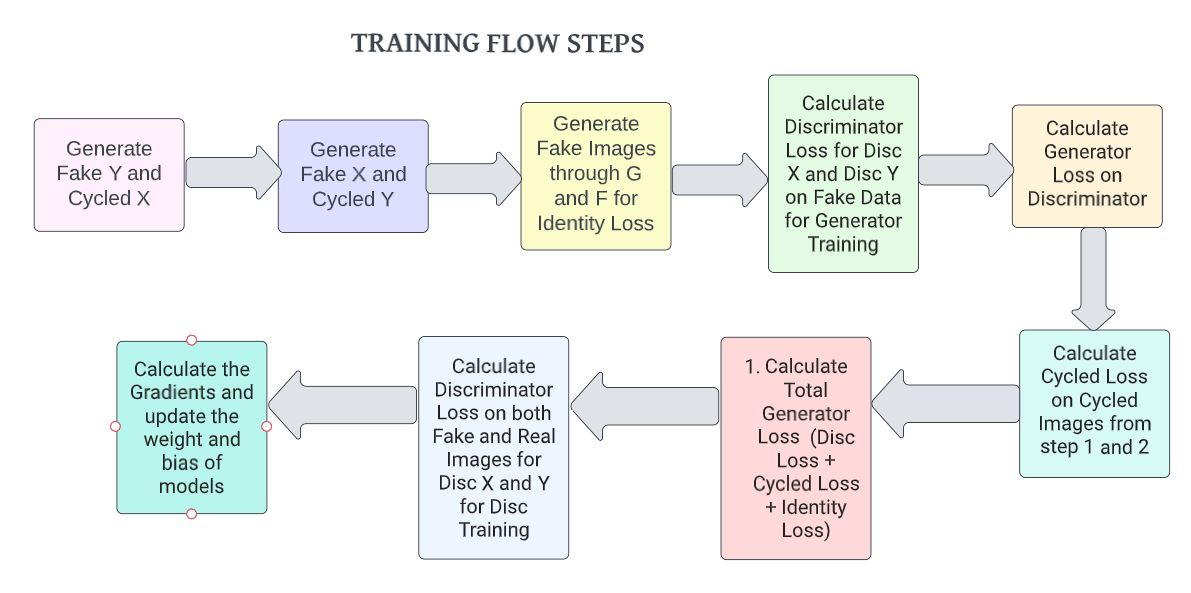

In [ ]:
# Let us decorate the function by using tf.function decorator provided by Tensorflow. 
# It converts regular python code to a callable Tensorflow graph function

@tf.function
def train_step(real_x, real_y):
    # Since the tape is used multiple times to calculate the gradients
    # so presistent should be set to True
    with tf.GradientTape(persistent=True) as tape:
        # The Generator G translates X to Y and vice versa for Generator F
        fake_y = unet_generatorG(real_x, training=True)
        cycled_x = unet_generatorF(fake_y, training=True)
        fake_x = unet_generatorF(real_y, training=True)
        cycled_y = unet_generatorG(fake_x, training=True)
        
        # To calculate the identity loss we use same_x and same_y
        same_x = unet_generatorF(real_x, training=True)
        same_y = unet_generatorG(real_y, training=True)
        
        disc_real_x = discriminatorX(real_x, training=True)
        disc_real_y = discriminatorY(real_y, training=True)
        
        disc_fake_x = discriminatorX(fake_x, training=True)
        disc_fake_y = discriminatorY(fake_y, training=True)
        
        # calculate both the generator loss
        gen_g_loss = lossFunctions.generator_loss(disc_fake_y)
        gen_f_loss = lossFunctions.generator_loss(disc_fake_x)
        
        total_cycle_loss = lossFunctions.calc_cycle_loss(real_x, cycled_x) + lossFunctions.calc_cycle_loss(real_y, cycled_y)
        
        # Calculate the total generator loss which is the sum of
        # BCE loss, cycle loss and identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + lossFunctions.identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + lossFunctions.identity_loss(real_x, same_x)
        
        # Calculate both the discriminators loss
        disc_x_loss = lossFunctions.discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = lossFunctions.discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the generator and discriminator gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, unet_generatorG.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, unet_generatorF.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminatorX.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminatorY.trainable_variables)
    
    # Let us now apply the gradients to the optimizer
    generatorG_optimizer.apply_gradients(zip(generator_g_gradients, unet_generatorG.trainable_variables))
    generatorF_optimizer.apply_gradients(zip(generator_f_gradients, unet_generatorF.trainable_variables))
    
    discriminatorX_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminatorX.trainable_variables))
    discriminatorY_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminatorY.trainable_variables))

#### Train the CycleGAN Model for 300 Epochs
Let us run the training function in loop for 300 epochs displaying the output at each step.

This also helps us visualize how Generators are getting better and producing realistic images every next epoch.

In [ ]:
# Let us train our model for 300 epochs
EPOCHS=300

In [ ]:
%%time
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((t1, t2)):
        train_step(image_x, image_y)
    generate_images(unet_generatorG, t1_image, unet_generatorF, t2_image, epoch)
    checkpoint_save_path = checkpoint_manager.save()
    print('Saving checkpoint and generated images saved after epoch', epoch, 'at', checkpoint_save_path)

### Generating a GIF of Generated Images

In [ ]:
# define the filename for creating the gif animation
gif_animation_file = 'cyclegan_mri.gif'

In [ ]:
# Generate the gif animation file
with imageio.get_writer(gif_animation_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# Install the following dependecy to embed gif in notebook if not installed
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v8nen7da
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v8nen7da
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=ae6314e1e40e337cbe7683803a80427015251c54e6fe7784d83963d6de2e711e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt7h06r_/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
# Embed the generated gif animation file
import tensorflow_docs.vis.embed as embed
embed.embed_file(gif_animation_file)

Hence we can observe through the gif animation as how the generated image got improvised after each training and also observe that from input image of T1 type MRI we get T2 type MRI generated and vice versa, which was our objective.

### Test the Trained Generators

Let us now test the generators and test if it converts T1 type MRI into T2 type and vice versa to validate. We can choose any random images from the image dataset.

In [ ]:
# Create a function to convert from one type of MRI to another and display result
# If the argument t1_to_t2 is true then it will convert from T1 to T2 else vice versa
def convertMRIAndDisplay(input_image, image_index, title1="Input Image", title2="Generated Image", t1_to_t2=True):
  plt.subplot(1, 2, 1)
  plt.title(title1)
  plt.imshow(input_image[image_index].numpy()[:, :, 0], cmap='gray')
  plt.subplot(1, 2, 2)
  plt.title(title2)
  if(t1_to_t2):
    plt.imshow(unet_generatorG(input_image)[image_index].numpy()[:, :, 0], cmap='gray')
  else:
    plt.imshow(unet_generatorF(input_image)[image_index].numpy()[:, :, 0], cmap='gray')
  plt.axis('off')
  plt.show()

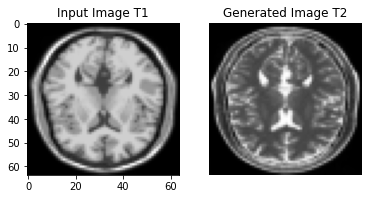

In [ ]:
# Convert from type T1 to Type T2 for index 1
convertMRIAndDisplay(t1_image, 1, "Input Image T1", "Generated Image T2")

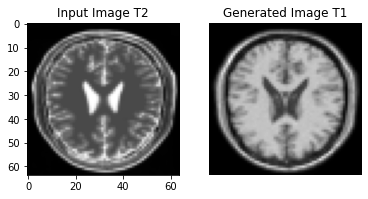

In [ ]:
# Convert from type T2 to Type T1 for index 6
convertMRIAndDisplay(t2_image, 6, "Input Image T2", "Generated Image T1", False)

**<font color="blue">Hence we observe that it correctly generates from type T1 to type T2 MRI and from type T2 to Type T1 MRI.</font>**

## Scope for further enhancement

Though it was not required for this project to deploy this solution, but we can make further enhancement to deploy the trained models with organized image pre-processing pipelines and exposing the end points as a REST API. 

The REST API can be created using either **Flask** or **FastAPI** and this API can be used to upload MRI images from a web application or a mobile application. The front end application (Web / Mobile) should have the feature of editing the image before finally uploading it. This edit feature should allow the user to center and crop / Scale the image to a satndard size before making the final upload.

After the image gets uploaded by the user, then it will pass through the following pre-processing pipeline:
- Normalize the image
- Resize the image
- Reshape the image

the image can further be pre-processed if required and then this would be fed to the generator depending on what the user has selected as input image (T1 or T2 on the front end user interface before uploading). 

Then according to the selected input by user it would be fed to the appropiate generator (G or F) to generate the required type of MRI image. This generated image can be downloaded.

There will also be an option to upload image in bulk rather than single image and then an option to download the multiple converted MRI images in zip format or any other suitable format depending on the requirement can be provided.

<font color="green">Provided below is a high level architecture diagram of the overall system. Please note that this is just a high level representation of minimal components and does not contain exhaustive list of componenets and services that may be present in actual implementation</font>

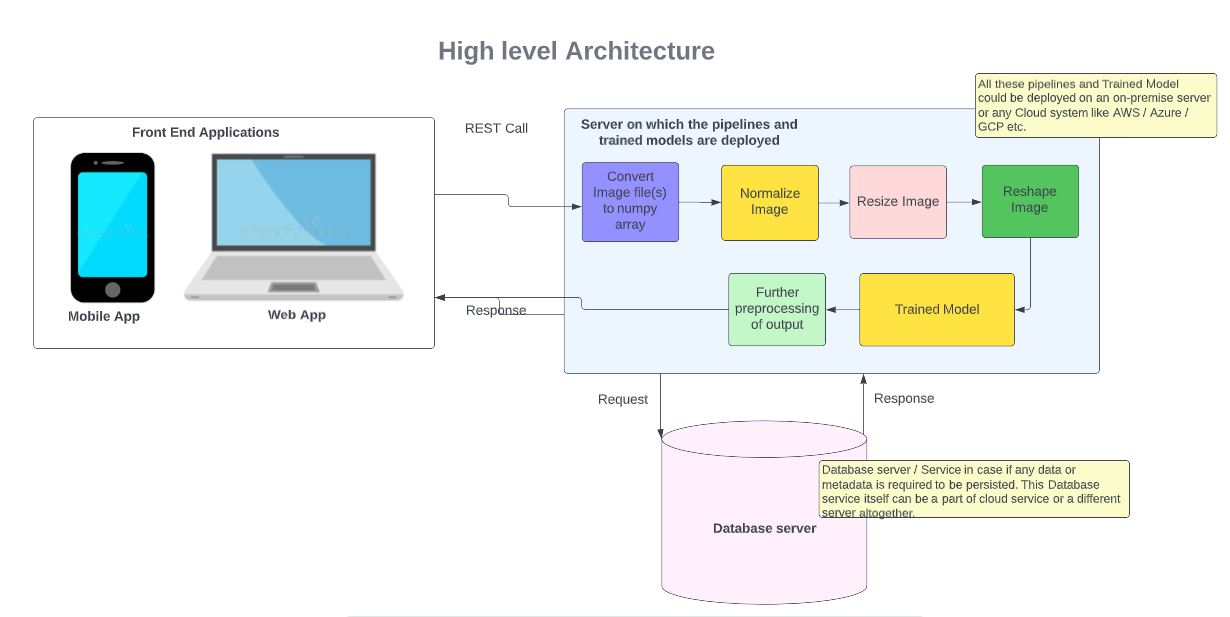

### <center><font color='#ccc'>===================================== End of Project =====================================</font></center>